In [ ]:
!pip install -q diffusers transformers accelerate safetensors pillow

In [ ]:
!pip freeze | grep -E "diffusers|transformers|accelerate|safetensors|pillow"

accelerate==1.12.0
diffusers==0.36.0
pillow==11.3.0
safetensors==0.7.0
sentence-transformers==5.2.0
transformers==4.57.3


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from diffusers import StableDiffusionInpaintPipeline

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [ ]:
model_id = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None
)

pipe = pipe.to("cuda")
pipe.enable_attention_slicing()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disable

Downloading...
From (original): https://drive.google.com/uc?id=1HOxR5LJ--lSHiqM6BwtX4Bj-oHIWWj70
From (redirected): https://drive.google.com/uc?id=1HOxR5LJ--lSHiqM6BwtX4Bj-oHIWWj70&confirm=t&uuid=33bab1a8-2a71-463f-bd3d-a5aa733acd8b
To: /content/input.png
100% 1.36M/1.36M [00:00<00:00, 174MB/s]


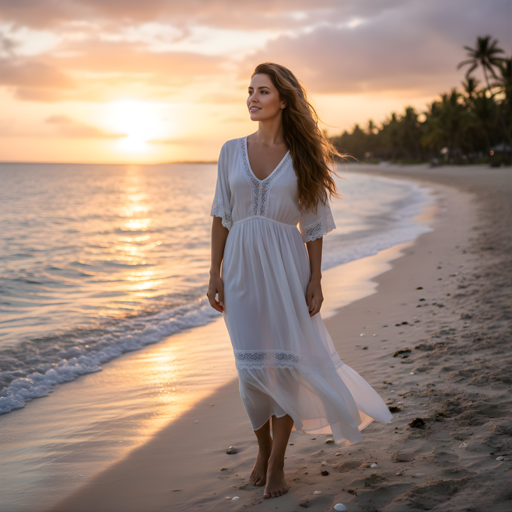

In [ ]:
url = "https://drive.google.com/file/d/1HOxR5LJ--lSHiqM6BwtX4Bj-oHIWWj70/view?usp=sharing"
!gdown "{url}" -O input.png --fuzzy

init_image = Image.open("input.png").convert("RGB")
init_image = init_image.resize((512, 512))
init_image

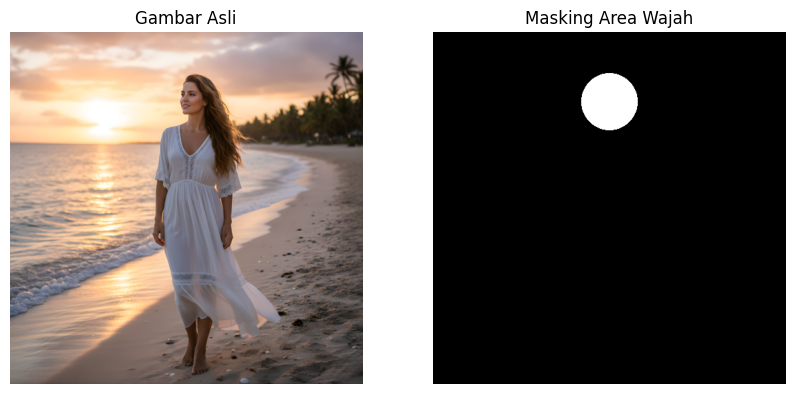

In [ ]:
mask = Image.new("L", init_image.size, 0)
draw = ImageDraw.Draw(mask)

width, height = init_image.size

# Koordinat mask
left = width * 0.42
top = height * 0.12
right = width * 0.58
bottom = height * 0.28

# Elips putih di wajah
draw.ellipse((left, top, right, bottom), fill=255)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(init_image)
plt.title("Gambar Asli")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Masking Area Wajah")
plt.axis("off")
plt.show()

  0%|          | 0/27 [00:00<?, ?it/s]

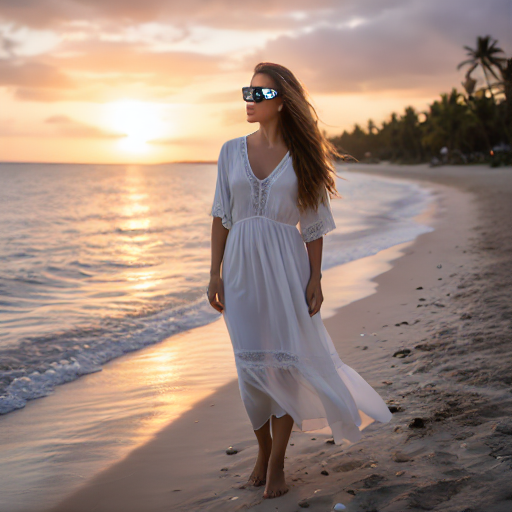

In [ ]:
prompt = "a woman wearing stylish black sunglasses, realistic, cinematic lighting"
negative_prompt = "bad anatomy, blurry, low quality, distorted face, ugly"

generator = torch.Generator("cuda").manual_seed(1024)

image_inpainting = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=init_image,
    mask_image=mask,
    guidance_scale=7.5,
    num_inference_steps=30,
    strength=0.9,
    generator=generator
).images[0]

image_inpainting

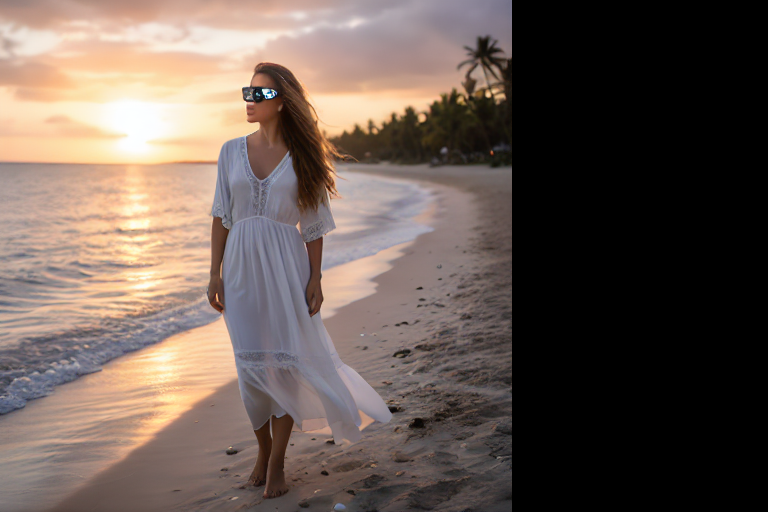

In [ ]:
# Lebar baru
old_width, old_height = image_inpainting.size
new_width = old_width + 256

outpaint_image = Image.new("RGB", (new_width, old_height))
outpaint_image.paste(image_inpainting, (0, 0))

outpaint_mask = Image.new("L", (new_width, old_height), 255)

original_area_mask = Image.new("L", (old_width, old_height), 0)
outpaint_mask.paste(original_area_mask, (0, 0))

outpaint_image

Sedang memperluas pantai...


  0%|          | 0/50 [00:00<?, ?it/s]

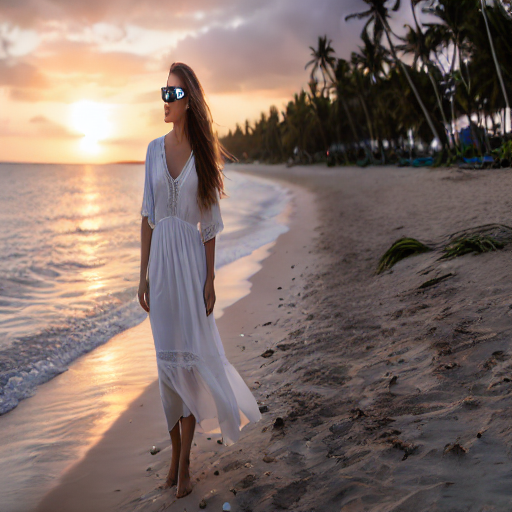

In [ ]:
prompt_outpaint = "beautiful tropical beach, white sand, palm trees on the right, ocean waves, sunset golden hour, photorealistic, 8k"

generator = torch.Generator("cuda").manual_seed(555)

print("Sedang memperluas pantai...")

image_outpainting = pipe(
    prompt=prompt_outpaint,
    negative_prompt=negative_prompt,
    image=outpaint_image,
    mask_image=outpaint_mask,
    guidance_scale=7.5,
    num_inference_steps=50,
    strength=1.0, # Strength 1.0 wajib untuk outpainting
    generator=generator
).images[0]

image_outpainting